#### Pairs Strategy (Buy and Hold) based on MACD Indicator

For this strategy, I have applied Moving Average Convergence Divergence (MACD) on ETQ-RRC pair. MACD is a trend following indicator which calculates a difference between two exponentially moving average (EMA) series with different lookback periods. The standard strategy calculates difference between 12 day EMA and 26 day EMA. A rolling mean with lookback of 9 days is created based on this difference and when MACD (current difference) indicator crosses over the rolling mean, a position is taken. 

Here, I have created a long only strategy on ETQ-RRC spread. The spread is calculated based on rolling linear regression between ETQ and RRC. Whenever the difference of rolling mean and MACD (current) changes sign from negative to positive a long position is taken in ETQ and RRC is shorted. The position is squared off when the sign changes back from positive to negative. Thus for this strategy, I hold the position for some days based on the strength of the crossover. 

I start with an initial capital of 10,000 and each position is for 100 shares. A graph for cummulative earnings is plotted. Sharpe ratio for the strategy is 0.54.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
def read_data(pd_frame):
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    data = pd.read_csv(pd_frame, parse_dates=['Date'], date_parser=dateparse)
    data = data.iloc[::-1]
    data = data.set_index('Date')
    data.name = pd_frame[-7:-4]
    return data

In [3]:
def combine_eqts(data1, data2):
      
    stk1 = read_data(data1)
    stk2 = read_data(data2)
    data = pd.DataFrame(index=stk1.index)
    data[stk1.name.lower()+'_Open'] = stk1['Open']
    data[stk2.name.lower()+'_Open'] = stk2['Open']
    data[stk1.name.lower()+'_Close'] = stk1['Close']
    data[stk2.name.lower()+'_Close'] = stk2['Close']
    return data, stk1.name.lower(), stk2.name.lower()


In [4]:
def spread(data, rolling_window=50):
    model = pd.stats.ols.MovingOLS(y=data.iloc[:,2], 
                   x=data.iloc[:,3], window_type = 'rolling', window=rolling_window,intercept=False)
    data['Close ratio'] = model.beta['x']
    data = data.dropna()

    data['Close spread'] = data.iloc[:,2] - data['Close ratio']*data.iloc[:,3]
    return data

In [5]:
data, stk1, stk2 = combine_eqts('data/etq.csv', 'data/rrc.csv')
data = spread(data)

In [6]:
data['12d_exma'] = pd.ewma(data['Close spread'], span=12)
data['26d_exma'] = pd.ewma(data['Close spread'], span=26)
data['MACD'] = data['12d_exma'] - data['26d_exma'] #12-26
data['MACD_signalline'] = pd.rolling_mean(data['MACD'], window=9)
data['MACD_hist'] = data['MACD'] - data['MACD_signalline']

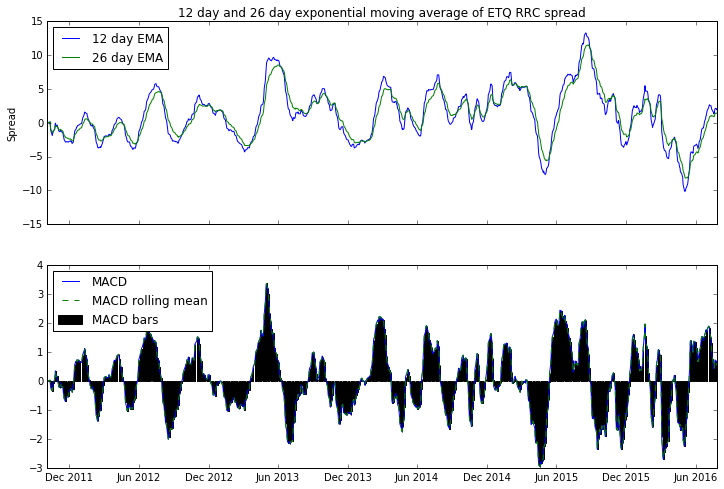

In [7]:
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(data.index, data["12d_exma"], label = '12 day EMA')
ax1.plot(data.index, data["26d_exma"],label = '26 day EMA')
ax1.set_ylabel("Spread")
legend = ax1.legend(loc = 'upper left')
ax1.set_title('12 day and 26 day exponential moving average of ETQ RRC spread')
ax2.bar(data.index, data["12d_exma"]-data["26d_exma"], label = 'MACD bars', facecolor='black')
# # ax2.fill_between(data.index, data['MACD'], data["MACD_signalline"], facecolor='red', interpolate=True)
ax2.plot(data.index, data["MACD"], label = 'MACD')
ax2.plot(data.index, data["MACD"], linestyle='--', label = 'MACD rolling mean')
legend = ax2.legend(loc = 'upper left')

In [8]:
a = np.zeros(len(data))
a[1::] = np.diff(np.signbit(-data["MACD_signalline"]+data["MACD"]))
data['zero_crossing'] = a

data['macd_pos'] = np.zeros(len(data))          
data['macd_pos'] = (data['MACD_hist'] > 0)*1.0

data['signal_gen_right'] = data['zero_crossing'].copy()
count = 0 
for i, row in data.iterrows():
    if row['signal_gen_right'] == 1:
        count = count + 1
        if count % 2 != 0:
            data.set_value(i,'signal_gen_right', 1)    

for i, row in data.iterrows():
    if row['signal_gen_right'] == 1 and row['zero_crossing']:
        data.set_value(i,'macd_pos', 1)    



In [9]:
data['Trade price long'] = np.zeros( data.shape[0])
data['Trade price short'] = np.zeros( data.shape[0])
for i, row in data.iterrows():
    if row['zero_crossing'] == 1:
        y = row[stk1 + '_Close']
        z = row[stk2 + '_Close']
        data.set_value(i,'Trade price long', y)
        data.set_value(i,'Trade price short', z)

        
data['Trade price long'].replace(to_replace=0,method='ffill', inplace=True)
data['Trade price long'] = data['Trade price long']*data['macd_pos']
data['Trade price short'].replace(to_replace=0,method='ffill', inplace=True)
data['Trade price short'] = data['Trade price short']*data['macd_pos']

data['long_profit'] = data['Trade price long'] - data['Trade price long'].shift(1)
data['short_profit'] = -1*(data['Trade price short'] - data['Trade price short'].shift(1))
data['long_short'] = data['long_profit'] + data['short_profit']

data['signal'] = data['zero_crossing']
# for i, row in data.iterrows():
#     if row['signal'] == 1:
#         y = 0
#         data.set_value(i,'signal', y)
        
#         break
count = 0
for i, row in data.iterrows():
    if row['signal'] == 1:
        count = count + 1
        if count % 2 != 0:
            data.set_value(i,'signal', 0)                   

In [10]:
data['total'] = 10000 + 100*(data['signal']*data['long_short']).cumsum()
data['returns'] = data['total'].pct_change()
data['returns'].fillna(0.0, inplace=True)
data['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
data['returns'].replace(-1.0, 0.0, inplace=True)
data['cum returns'] = (data['returns'] + 1.0).cumprod()
# data.to_excel('MACD_Pairs.xlsx')
sharpe_ratio = (data['returns'].mean()*np.sqrt(252))/data['returns'].std()
print 'Sharpe ratio is %f' % (sharpe_ratio)

Sharpe ratio is 0.545113


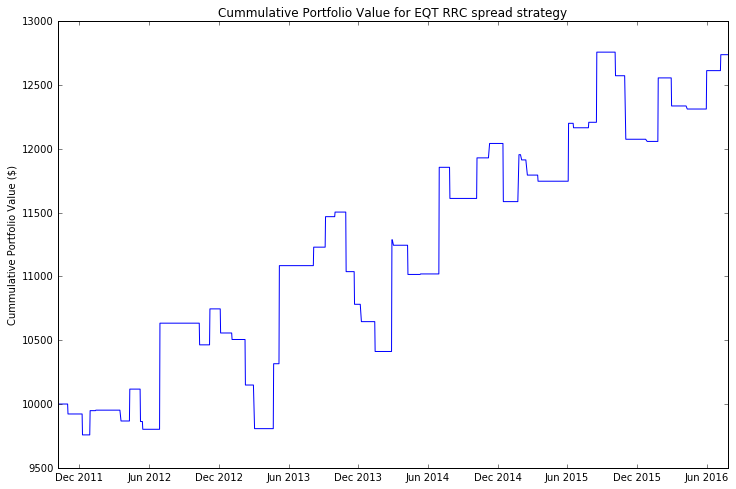

In [11]:
f, ax1 = plt.subplots(1)
ax1.plot(data.index, data['total'])
ax1.set_ylabel("Cummulative Portfolio Value ($)")
ax1.set_title("Cummulative Portfolio Value for EQT RRC spread strategy")